# 量子アルゴリズム: 変分量子アルゴリズム

<Admonition type="note">
  Created by Takashi Imamichi on 2024/05/24,

Modified by Hiromichi Hayashi on 2025/10/29.

[Original material](https://quantum-tokyo.github.io/introduction/courses/utility-scale-quantum-computing/variational-quantum-algorithms-ja.html)

[English material](https://quantum.cloud.ibm.com/learning/en/courses/utility-scale-quantum-computing/variational-quantum-algorithms)

</Admonition>


## 1. はじめに

このチュートリアルでは、量子古典ハイブリッドアルゴリズムの概要を説明し、特に変分量子固有値ソルバー (VQE) と量子近似最適化アルゴリズム (QAOA) に焦点を当てます。これらのアルゴリズムの主な目的は、パラメーター化された量子ゲートを備えた量子回路を使って最適化の問題に取り組むことです。

量子コンピューティングの進歩にもかかわらず、現在の量子デバイスにはノイズが存在するため、深い量子回路から意味のある結果を抽出することが困難になっています。この課題を克服するために、VQE と QAOA は、量子計算を使用して比較的短い量子回路を反復的に実行し、古典計算を使用して目的となるパラメータ化された量子回路のパラメーターを最適化するハイブリッド量子古典的アプローチです。

QAOA は、さまざまなエラー緩和・抑制技術の適用により、ユーティリティー規模の問題に対する最適なソリューションを提供する可能性があります。VQE には、拡張性が低い多くのアプリケーション(量子化学など)があります。しかし、クリロフ部分空間対角化やサンプルベースの量子対角化(SQD)など、VQE を補完および拡張するための固有値関連のアプローチが数多く登場しています。VQE を理解することは、幅広い古典量子ハイブリッドアルゴリズムを理解するための重要な第一歩です。

このモジュールでは、VQE と QAOA の基本的な概念と実装について説明します。今後のチュートリアルでは、これらのアルゴリズムをスケールアップするための高度なトピックとテクニックについて説明します。


このノートブックを実行するには、環境に次のライブラリーが必要です。まだインストールしていない場合は、コメントを解除して次のセルを実行することでインストールできます。


In [43]:
# % pip install qiskit[visualization] qiskit-ibm-runtime

## 2. 簡単なハミルトニアンの最小固有値の計算

VQE を非常に単純なケースに適用して、それがどのように機能するかを確認することから始めます。VQE でパウリ $Z$ 行列の最小固有値を計算します。まず、いくつかの一般的なパッケージをインポートします。


In [44]:
import numpy as np
from qiskit.circuit import ParameterVector, QuantumCircuit
from qiskit.primitives import StatevectorEstimator, StatevectorSampler
from qiskit.quantum_info import SparsePauliOp
from scipy.optimize import minimize

はじめに、目的の演算子を定義し、行列形式で表示します。


In [45]:
op = SparsePauliOp("Z")
op.to_matrix()

array([[ 1.+0.j,  0.+0.j],
       [ 0.+0.j, -1.+0.j]])

この固有値を古典的に取得するのは簡単なので、ここで確認のために計算します。この計算は、ユーティリティー規模に拡大するにつれて困難になる可能性があります。ここでは numpy を使用します。


In [46]:
# compute eigenvalues with numpy
result = np.linalg.eigh(op.to_matrix())
print("Eigenvalues:", result.eigenvalues)

Eigenvalues: [-1.  1.]


変分量子アルゴリズムを使用して固有値を取得するために、変分パラメーターを使うゲートを用いた回路を構築します。


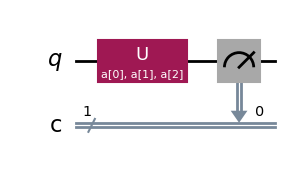

In [47]:
# define a variational form
param = ParameterVector("a", 3)
qc = QuantumCircuit(1, 1)
qc.u(param[0], param[1], param[2], 0)
qc_estimator = qc.copy()
qc.measure(0, 0)
qc.draw("mpl")

演算子の期待値( $Z$ など)を推定したい場合は、Estimator を使用する必要があります。システムの状態を調べたい場合は、Sampler を使用します。


In [48]:
sampler = StatevectorSampler()
estimator = StatevectorEstimator()

Sampler を使用して、ランダムなパラメーター値 `[1, 2, 3]` を使用してビット文字列 0 と 1 のカウントを計算できます。


In [49]:
# compute counts of bitstrings with random parameter values by Sampler
result = sampler.run([(qc, [1, 2, 3])]).result()
counts = result[0].data.c.get_counts()
counts

{'0': 800, '1': 224}

Z の期待値は、$\langle Z \rangle = p_0 - p_1$で、確率は$\{0:p_0, 1:p_1\}$で計算できることがわかっています。


In [50]:
# compute the expectation value of Z based on the counts
(counts.get("0", 0) - counts.get("1", 0)) / sum(counts.values())

0.5625

この回路は機能しましたが、選択されたパラメーター値は、非常に低エネルギー(または低い固有値)の状態に対応していませんでした。得られる固有値は最小値よりかなり高いです。Estimator を使用する場合も、結果は同様です。

Estimator は測定なしで量子回路を取得することに注意してください。


In [51]:
result = estimator.run([(qc_estimator, op, [1, 2, 3])]).result()
result[0].data.evs

array(0.54030231)

パラメーターを検索して、最も低い固有値を生成するパラメーターを見つける必要があります。
変分形式のパラメーター値を受け取り、期待値$\langle Z \rangle$を返す関数を作成します。


In [52]:
# define a cost function to look for the minimum eigenvalue of Z
def cost(x):
    result = sampler.run([(qc, x)]).result()
    counts = result[0].data.c.get_counts()
    expval = (counts.get("0", 0) - counts.get("1", 0)) / sum(counts.values())
    # the following line shows the trajectory of the optimization
    print(expval, counts)
    return expval

SciPy の `minimize` 関数を適用して、Z の最小固有値を見つけましょう。


In [53]:
# minimize the cost function with scipy's minimize
min_result = minimize(cost, [0, 0, 0], method="COBYLA", tol=1e-8)
min_result

1.0 {'0': 1024}
0.546875 {'0': 792, '1': 232}
0.529296875 {'0': 783, '1': 241}
0.513671875 {'0': 775, '1': 249}
-0.40625 {'1': 720, '0': 304}
-0.673828125 {'0': 167, '1': 857}
-0.388671875 {'1': 711, '0': 313}
-0.51953125 {'0': 246, '1': 778}
-0.607421875 {'1': 823, '0': 201}
-0.12890625 {'1': 578, '0': 446}
-0.93359375 {'1': 990, '0': 34}
-0.984375 {'1': 1016, '0': 8}
-1.0 {'1': 1024}
-0.998046875 {'1': 1023, '0': 1}
-0.99609375 {'1': 1022, '0': 2}
-1.0 {'1': 1024}
-1.0 {'1': 1024}
-1.0 {'1': 1024}
-1.0 {'1': 1024}
-1.0 {'1': 1024}
-0.998046875 {'1': 1023, '0': 1}
-1.0 {'1': 1024}
-1.0 {'1': 1024}
-1.0 {'1': 1024}
-0.998046875 {'1': 1023, '0': 1}
-1.0 {'1': 1024}
-1.0 {'1': 1024}
-0.998046875 {'1': 1023, '0': 1}
-1.0 {'1': 1024}
-1.0 {'1': 1024}
-1.0 {'1': 1024}
-1.0 {'1': 1024}
-1.0 {'1': 1024}
-1.0 {'1': 1024}
-1.0 {'1': 1024}
-1.0 {'1': 1024}


 message: Return from COBYLA because the trust region radius reaches its lower bound.
 success: True
  status: 0
     fun: -1.0
       x: [ 3.113e+00  8.250e-01  1.700e+00]
    nfev: 36
   maxcv: 0.0

In [54]:
# check counts of bitstrings with the optimal parameters
result = sampler.run([(qc, min_result.x)]).result()
result[0].data.c.get_counts()

{'1': 1022, '0': 2}

### 2.1 演習

VQE を使用して $Z \otimes Z$ の最小固有値を計算します。


In [55]:
z2 = SparsePauliOp("ZZ")
print(z2)
print(z2.to_matrix())

SparsePauliOp(['ZZ'],
              coeffs=[1.+0.j])
[[ 1.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j -1.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j -1.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j  1.+0.j]]


In [56]:
# compute eigenvalues with numpy

In [57]:
# define a variational form
# qc = ...

In [58]:
# compute counts of bitstrings with a random parameter values by Sampler
# result = sampler.run(...)
# result

In [59]:
# compute the expectation value of ZZ based on the counts

In [60]:
# verify the expectation value of ZZ with Estimator

In [61]:
# define a cost function to look for the minimum eigenvalue of ZZ
# def cost(x):
#    expval = ...
#    return expval

In [62]:
# minimize the cost function with scipy's minimize
# min_result = minimize(cost, [...], method="COBYLA", tol=1e-8)
# min_result

In [63]:
# check counts of bitstrings with the optimal parameter values
# result = sampler.run(qc, min_result.x).result()
# result

## 3. Qiskit patterns による量子最適化

このハウツーでは、Qiskit patterns と量子近似最適化について学習します。Qiskit patterns は、量子コンピューティングのワークフローを実装するための直感的で反復可能な一連の手順です。


!["Qiskit function"](https://quantum.cloud.ibm.com/assets-docs-learning/_next/image?url=%2Flearning%2Fimages%2Fcourses%2Futility-scale-quantum-computing%2Fvariational-quantum-algorithms%2Fqiskit-function.avif&w=1200&q=75)


Qiskit patterns を **組合せ最適化** に適用し、ハイブリッド(量子古典)反復手法である **量子近似最適化アルゴリズム(QAOA)** を使用して **Max-Cut** 問題を解く方法を示します。


### 3.1 (小規模) 最適化のための Qiskit patterns


このパートでは、小規模な Max-Cut 問題で、量子コンピューターを使用して最適化問題を解くために必要な手順を示します。


Max-Cut 問題は、クラスタリング、ネットワーク科学、統計物理学など、さまざまな用途で解くのが難しい最適化問題(より具体的には NP 難問題)です。このチュートリアルでは、エッジで接続されたノードのグラフを検討し、カットされたエッジの数が最大化されるように、エッジを「カット」してノードを 2 つのセットに分割することを目的としています。


!["Maxcut"](https://quantum.cloud.ibm.com/assets-docs-learning/_next/image?url=%2Flearning%2Fimages%2Fcourses%2Futility-scale-quantum-computing%2Fvariational-quantum-algorithms%2Fmaxcut.avif&w=3840&q=75)


量子アルゴリズムにこの問題をマッピングする前に、まず関数 $f(x)$ の最小化を考えることで、Max-Cut 問題がどのように古典的な組合せ最適化問題になるのかを理解することができます。

$$
\min_{x\in \{0, 1\}^n} f(x),
$$

ここで入力 $x$ はベクトルで、その成分はグラフの各ノードに対応します。そして各成分を $0$ または $1$ のいずれかに制約します（それぞれカットに含まれるか含まれないかを表します）。ここでは例として $n=5$ ノードのグラフを扱います。

ノードのペア $i,j$ に対して、その対応する辺 $(i,j)$ がカットに含まれているかを示す関数を定義することができます。たとえば、関数 $x_i + x_j - 2 x_i x_j$ は、 $x_i$ または $x_j$ のいずれか一方が 1 のとき（つまりその辺がカットに含まれるとき）だけ 1 となり、それ以外では 0 になります。

カットに含まれる辺の数を最大化する問題は次のように定式化できます。

$$
\max_{x\in \{0, 1\}^n} \sum_{(i,j)} x_i + x_j - 2 x_i x_j,
$$

これは次のような最小化問題に書き換えることができます。

$$
\min_{x\in \{0, 1\}^n} \sum_{(i,j)}  2 x_i x_j - x_i - x_j.
$$

このとき、$f(x)$ の最小値は、カットが通過する辺の数が最大であるときに達成されます。ご覧のとおり、この時点ではまだ量子コンピュータに関連するものは登場していません。この問題を量子コンピュータが理解できる形に再定式化する必要があります。


$n=5$ ノードを持つグラフを作成して、問題を初期化します。


In [66]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import rustworkx as rx
from rustworkx.visualization import mpl_draw

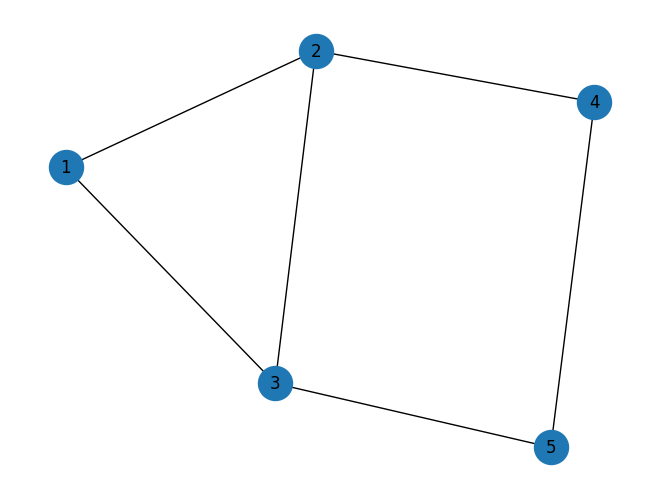

In [67]:
n = 5

graph = rx.PyGraph()
graph.add_nodes_from(range(1, n + 1))
edge_list = [
    (0, 1, 1.0),
    (0, 2, 1.0),
    (1, 2, 1.0),
    (1, 3, 1.0),
    (2, 4, 1.0),
    (3, 4, 1.0),
]
graph.add_edges_from(edge_list)
pos = rx.spring_layout(graph, seed=2)
mpl_draw(graph, node_size=600, pos=pos, with_labels=True, labels=str)

### 3.2 Step 1. 古典的入力を量子問題へマッピングする

このパターンの最初のステップは、古典的な問題（グラフ）を量子 **回路** や **演算子** にマッピングすることです。これを行うために、以下の 3 つの主要なステップを踏みます。

1. 一連の数学的な書き換えを利用し、この問題を「制約のない二次二値最適化（Quadratic Unconstrained Binary Optimization, QUBO）」の表記を使って表す。
2. 最適化問題を書き換えて、基底状態がコスト関数を最小化する解に対応するようなハミルトニアンにする。
3. 量子アニーリングに似たプロセスによって、このハミルトニアンの基底状態を準備する量子回路を作成する。

**注意:** QAOA（量子近似最適化アルゴリズム）の手法においては、最終的に必要なのは、ハイブリッドアルゴリズムの **コスト関数** を表す演算子（**ハミルトニアン**）と、問題の候補解に対応する量子状態を表すパラメーター化された回路（**アンザッツ**）です。これらの候補状態をサンプリングし、その後コスト関数を使って評価することができます。

#### グラフ → 最適化問題

マッピングの最初のステップは表記の変更です。以下のように、この問題を QUBO 表記で表すことができます。

$$
\min_{x\in \{0, 1\}^n}x^T Q x,
$$

ここで $Q$ は実数の $n \times n$ 行列、$n$ はグラフのノードの数、$x$ は先ほど導入した二値変数のベクトル、そして $x^T$ は $x$ の転置を表します。


```
Problem name: maxcut

Minimize
  2*x_1*x_2 + 2*x_1*x_3 + 2*x_2*x_3 + 2*x_2*x_4 + 2*x_3*x_5 + 2*x_4*x_5 - 2*x_1
  - 3*x_2 - 3*x_3 - 2*x_4 - 2*x_5

Subject to
  No constraints

  Binary variables (5)
    x_1 x_2 x_3 x_4 x_5
```


#### 最適化問題 → ハミルトニアン

次に、QUBO 問題を **ハミルトニアン**（ここでは、系のエネルギーを表す行列）として再定式化することができます：

$$
H_C=\sum_{ij}Q_{ij}Z_iZ_j + \sum_i b_iZ_i.
$$

**QAOA 問題からハミルトニアンへの再定式化ステップ**

QAOA 問題がこのように書き換えられることを示すために、まず二値変数 $x_i$ を新しい変数 $z_i\in\{-1,1\}$ に置き換えます：

$$
x_i = \frac{1-z_i}{2}.
$$

ここでわかるように、もし $x_i=0$ であれば $z_i=1$ でなければなりません。$x_i$ を $z_i$ に置き換えて最適化問題（$x^TQx$）に代入すると、同値な定式化が得られます。

$$
x^TQx=\sum_{ij}Q_{ij}x_ix_j \\ =\frac{1}{4}\sum_{ij}Q_{ij}(1-z_i)(1-z_j) \\=\frac{1}{4}\sum_{ij}Q_{ij}z_iz_j-\frac{1}{4}\sum_{ij}(Q_{ij}+Q_{ji})z_i + \frac{n^2}{4}.
$$

ここで $b_i=-\sum_{j}(Q_{ij}+Q_{ji})$ と定義し、係数や定数項 $n^2$ を取り除くと、同じ最適化問題の二つの同値な定式化に到達します：

$$
\min_{x\in\{0,1\}^n} x^TQx \Longleftrightarrow \min_{z\in\{-1,1\}^n} z^TQz + b^Tz
$$

ここで $b$ は $Q$ に依存します。なお、$z^TQz + b^Tz$ を得るために、1/4 の係数と $n^2$ の定数項を無視しました。これらは最適化においては役割を果たさないためです。

次に、問題を量子形式にするために、変数 $z_i$ をパウリ $Z$ 行列に置き換えます。例えば、次のような $2\times 2$ の行列です：

$$
Z_i = \begin{pmatrix}1 & 0 \\ 0 & -1\end{pmatrix}.
$$

この行列を最適化問題に代入すると、次のようなハミルトニアンが得られます：

$$
H_C=\sum_{ij}Q_{ij}Z_i Z_j + \sum_i b_i Z_i.
$$

_また、$Z$ 行列は量子コンピュータの計算空間、すなわち $2^n \times 2^n$ のヒルベルト空間に埋め込まれていることに注意してください。したがって $Z_i Z_j$ のような項は、$2^n \times 2^n$ のヒルベルト空間におけるテンソル積 $Z_i \otimes Z_j$ として理解する必要があります。たとえば、5 つの決定変数を持つ問題において $Z_1Z_3$ という項は、$I \otimes Z_3 \otimes I \otimes Z_1 \otimes I$ を意味します。ここで $I$ は $2 \times 2$ の単位行列です。_

このハミルトニアンは **コスト関数ハミルトニアン** と呼ばれます。その基底状態が **コスト関数 $f(x)$ を最小化する解** に対応するという性質を持ちます。したがって、最適化問題を解くには、量子コンピュータ上で $H_C$ の基底状態（あるいはそれと高い重なりを持つ状態）を準備する必要があります。そして、この状態からサンプリングすることで、高い確率で $\min f(x)$ の解を得ることができます。


In [68]:
def build_max_cut_operator(graph: rx.PyGraph) -> tuple[SparsePauliOp, float]:
    sp_list = []
    constant = 0
    for s, t in graph.edge_list():
        w = graph.get_edge_data(s, t)
        sp_list.append(("ZZ", [s, t], w / 2))
        constant -= 1 / 2
    return SparsePauliOp.from_sparse_list(sp_list, num_qubits=graph.num_nodes()), constant

In [69]:
cost_hamiltonian, constant = build_max_cut_operator(graph)
print("Cost Function Hamiltonian:", cost_hamiltonian)
print("Constant:", constant)

Cost Function Hamiltonian: SparsePauliOp(['IIIZZ', 'IIZIZ', 'IIZZI', 'IZIZI', 'ZIZII', 'ZZIII'],
              coeffs=[0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j])
Constant: -3.0


#### ハミルトニアン → 量子回路


ハミルトニアン $H_C$ には、問題の量子版の定義が含まれています。ここから、量子コンピュータから「良い解」を _サンプリング_ するのに役立つ量子回路を作ることができます。QAOA は量子アニーリングに着想を得ており、量子回路の中で演算子を交互に適用する層を重ねていきます。

基本的なアイデアは、既知の系の基底状態（上記の $H^{\otimes n}|0\rangle$）から始め、目的とするコスト演算子の基底状態へと系を導いていくというものです。これは、角度 $\gamma_1, \dots, \gamma_p$ および $\beta_1, \dots, \beta_p$ をパラメータとして持つ演算子 $
\exp\{-i\gamma_k H_C\}, \quad \exp\{-i\beta_k H_m\}$ を適用することによって行われます。

生成される量子回路は $\gamma_i$ と $\beta_i$ によって **パラメーター化** されているので、これらの値をさまざまに試し、その結果得られる状態からサンプリングを行うことができます。


この場合、2 つのパラメーター $\gamma_1$ と $\beta_1$ を含む **1 層の QAOA** の例を試してみます。


In [72]:
from qiskit.circuit.library import QAOAAnsatz

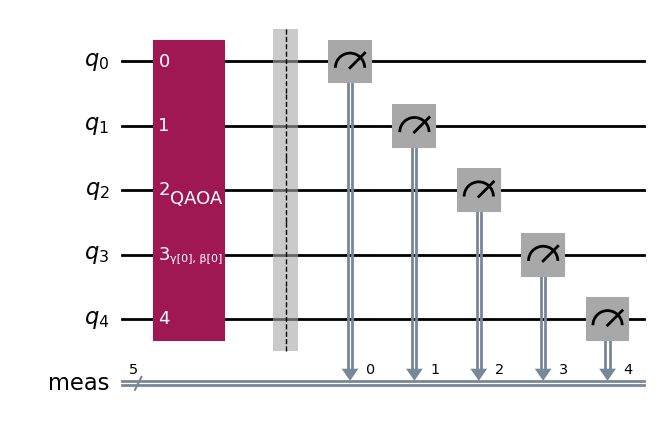

In [73]:
circuit = QAOAAnsatz(cost_operator=cost_hamiltonian, reps=1)
circuit.measure_all()
circuit.draw("mpl")

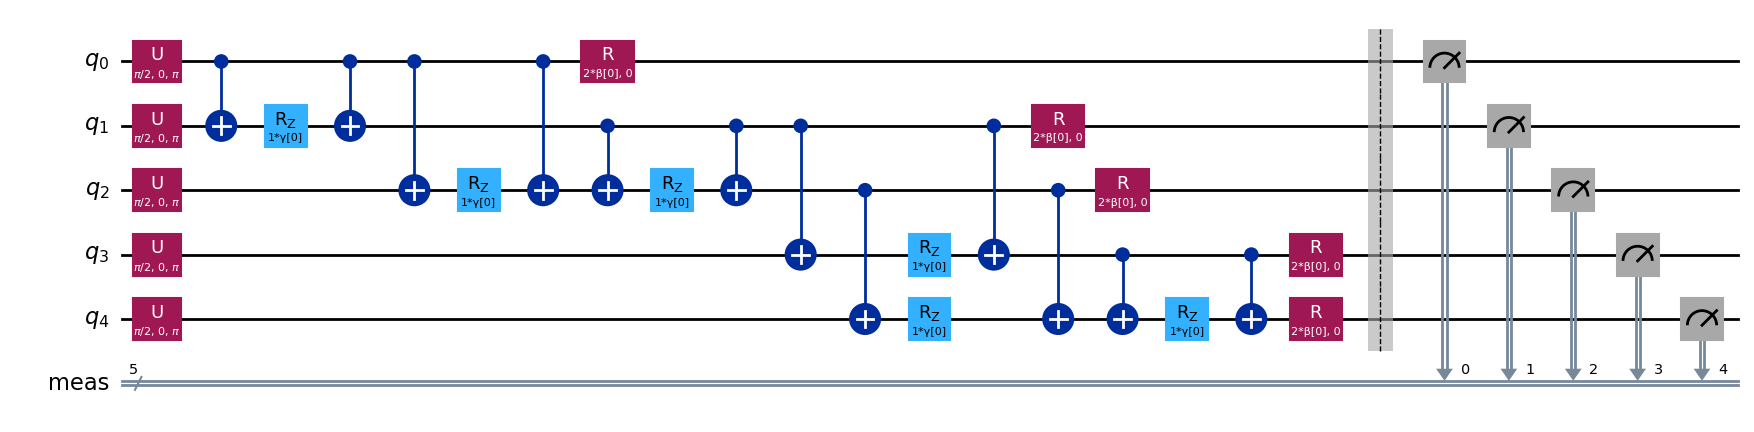

In [74]:
circuit.decompose(reps=3).draw("mpl", fold=-1)

In [75]:
circuit.parameters

ParameterView([ParameterVectorElement(β[0]), ParameterVectorElement(γ[0])])

In [50]:
# Check Qiskit version
import qiskit

qiskit.__version__

'2.1.2'

© IBM Corp., 2017-2025
